- Prepare the data via cleaning, normalization, encoding categorical variables, etc.
- Generate and evaluate a working linear model
- Enhance your model results by trying different model and/or data enhancement techniques, building 3 models with different regularization and feature engineering techniques
- Evaluate your models using multiple performance metrics and explain your choice of model
- Draw direct inferences and conclusions from model results (describe how your model results can improve or provide a solution to the problem you have chosen)
- Use graphs and evidence from the data to prove your conclusions in a form that tells a story that helps the a non-technical person in the business



For this exercise, we will only look at properties with:
- 0-10 bedrooms

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy
import scipy.stats as ss
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.weightstats as ws
import statsmodels.stats.power as smsp
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import scale
from patsy import dmatrices
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
from sklearn.metrics import mean_squared_error

%matplotlib inline

url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
df = pd.read_csv(url)

df['year'] = pd.DatetimeIndex(df['date']).year
df['age'] = df['year']-df['yr_built']
df.loc[df['age']<0,'age'] = 0


df['basement'] = 0
df.loc[df['sqft_basement']>0,'basement'] = 1


df.where((df['bedrooms']<=10), inplace=True)


df.dropna(inplace=True)

df.drop(['id', 'date', 'year'], axis=1, inplace=True)
df.drop(['yr_built', 'yr_renovated', 'sqft_basement'], axis=1, inplace=True)

df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,age,basement
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,98178.0,47.5112,-122.257,1340.0,5650.0,59.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,98125.0,47.7210,-122.319,1690.0,7639.0,63.0,1.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,98028.0,47.7379,-122.233,2720.0,8062.0,82.0,0.0


In [4]:
for i in ['price', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', #'sqft_basement', 
          'zipcode', 'sqft_living15', 'sqft_lot15', 'age', 'basement']:
    df[i] = df[i].astype('int')

    
for j in ['zipcode']: #, 'waterfront', 'basement', 'view', 'condition', 'grade']:
    df[j] = df[j].astype('category')  
    
    
df.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,zipcode,lat,long,sqft_living15,sqft_lot15,age,basement
0,221900,3.0,1.00,1180,5650,1.0,0,0,3,7,1180,98178,47.5112,-122.257,1340,5650,59,0
1,538000,3.0,2.25,2570,7242,2.0,0,0,3,7,2170,98125,47.7210,-122.319,1690,7639,63,1
2,180000,2.0,1.00,770,10000,1.0,0,0,3,6,770,98028,47.7379,-122.233,2720,8062,82,0


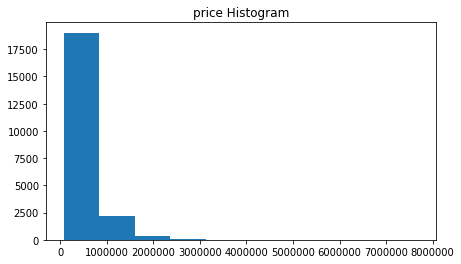

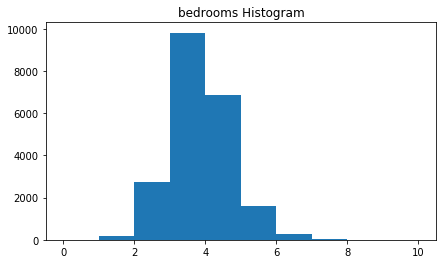

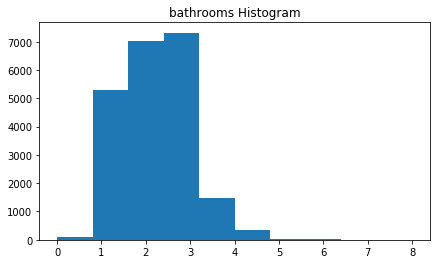

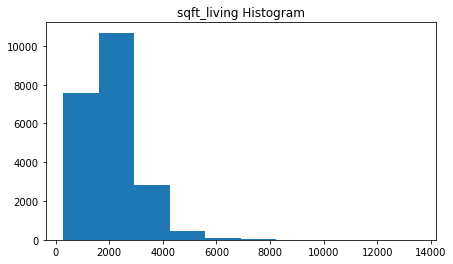

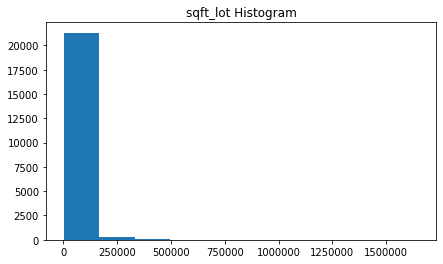

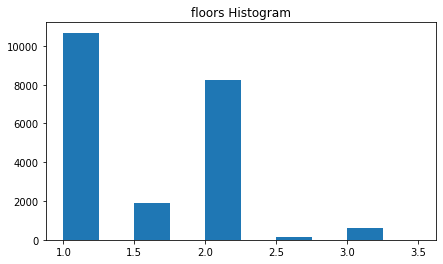

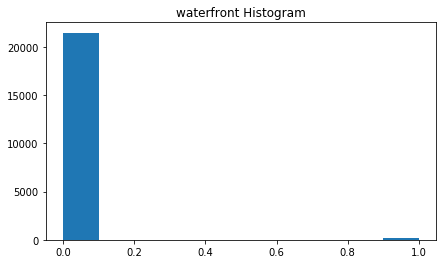

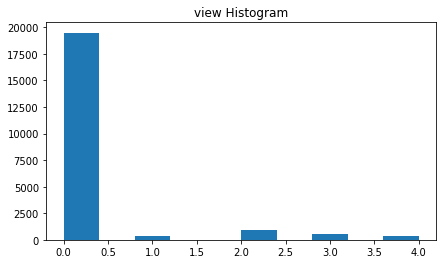

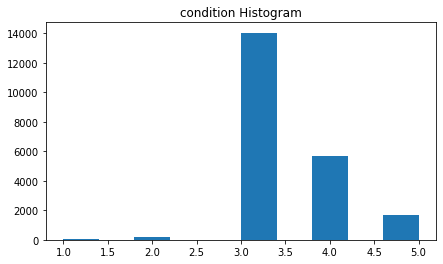

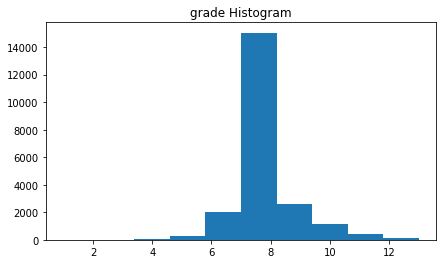

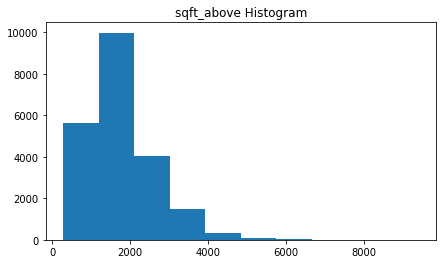

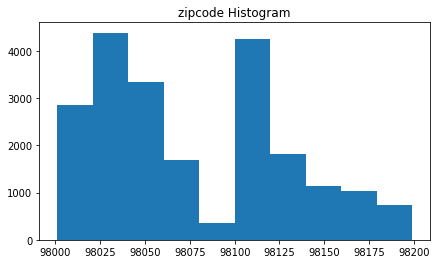

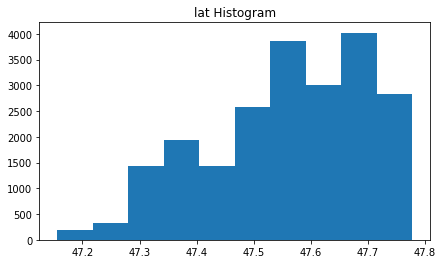

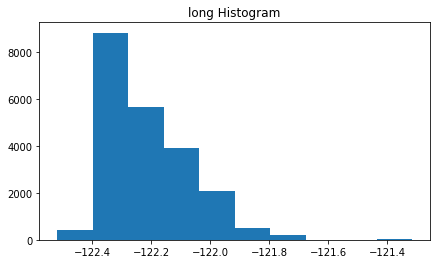

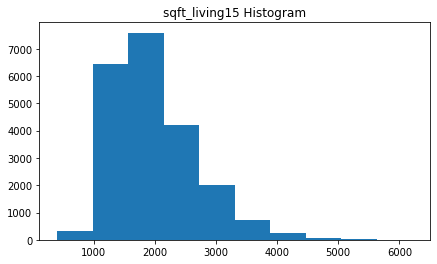

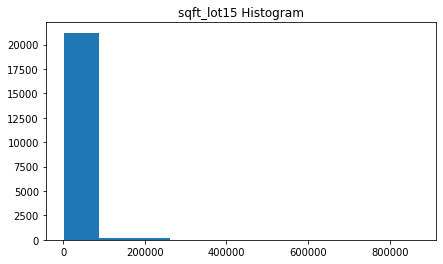

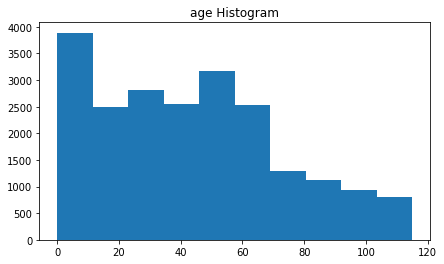

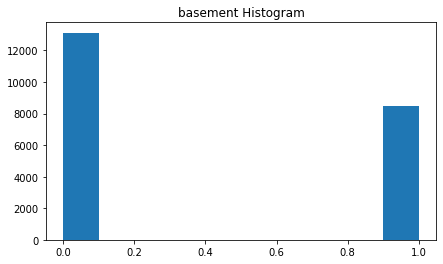

In [5]:
for i in df.columns:
    plt.figure(figsize=[7,4])
    plt.hist(df[i])
    plt.title(i+' Histogram')
    plt.show()

In [6]:
print('\nData types')
print(df.dtypes)

print('\nCheck for missing value')
print(df.isnull().any())

print('\nDataset shape: ')
print(df.shape)


Data types
price               int64
bedrooms          float64
bathrooms         float64
sqft_living         int64
sqft_lot            int64
floors            float64
waterfront          int64
view                int64
condition           int64
grade               int64
sqft_above          int64
zipcode          category
lat               float64
long              float64
sqft_living15       int64
sqft_lot15          int64
age                 int64
basement            int64
dtype: object

Check for missing value
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
age              False
basement         False
dtype: bool

Dataset shape: 
(21611, 18)


In [7]:
price_mean = np.mean(df['price'])
price_stdev = np.std(df['price'])

print('Price Mean :', np.round(price_mean,2))
print('Price Stdev :', np.round(price_stdev,2))

Price Mean : 540084.45
Price Stdev : 367135.04


In [8]:
print('Dataset Summary Statistics')
print(df.describe())

Dataset Summary Statistics
              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.161100e+04  21611.000000  21611.000000  21611.000000  2.161100e+04   
mean   5.400844e+05      3.369118      2.114733   2079.878442  1.510786e+04   
std    3.671435e+05      0.906518      0.770171    918.456742  4.142232e+04   
min    7.500000e+04      0.000000      0.000000    290.000000  5.200000e+02   
25%    3.217250e+05      3.000000      1.750000   1426.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.620000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068850e+04   
max    7.700000e+06     10.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21611.000000  21611.000000  21611.000000  21611.000000  21611.000000   
mean       1.494308      0.007542      0.234325      3.409375      7.656934   
std        0.539992     

In [9]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'age', 'basement'],
      dtype='object')

In [10]:
#one hot encoding categorical factors (waterfront, zipcode)

df2 = df.copy(deep=True)

#for j in ['waterfront']:
#    df_ohe = pd.get_dummies(df[j], prefix=j, columns=[j])
#    df2 = pd.concat([df2, df_ohe], axis=1)
#    df2.drop(columns = [j], inplace=True)


loglist = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']    

for col in loglist:
    df2.loc[:, col+'_log'] = np.log(df2.loc[:,col])
    df2.drop([col], axis=1, inplace=True)


print(df2.head(3), '\n')

   bedrooms  bathrooms  floors  waterfront  view  condition  grade zipcode  \
0       3.0       1.00     1.0           0     0          3      7   98178   
1       3.0       2.25     2.0           0     0          3      7   98125   
2       2.0       1.00     1.0           0     0          3      6   98028   

       lat     long  age  basement  price_log  sqft_living_log  sqft_lot_log  \
0  47.5112 -122.257   59         0  12.309982         7.073270      8.639411   
1  47.7210 -122.319   63         1  13.195614         7.851661      8.887653   
2  47.7379 -122.233   82         0  12.100712         6.646391      9.210340   

   sqft_above_log  sqft_living15_log  sqft_lot15_log  
0        7.073270           7.200425        8.639411  
1        7.682482           7.432484        8.941022  
2        6.646391           7.908387        8.994917   



In [11]:
df2.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode', 'lat', 'long', 'age', 'basement', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

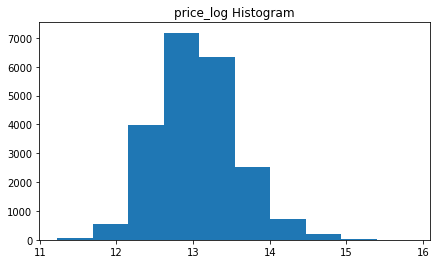

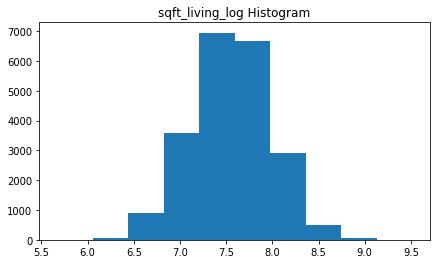

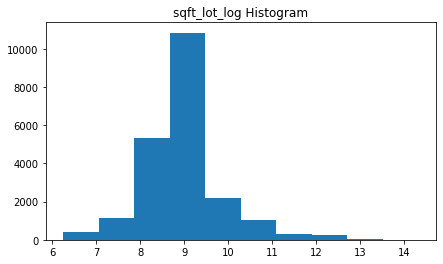

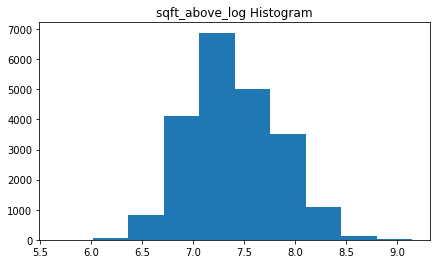

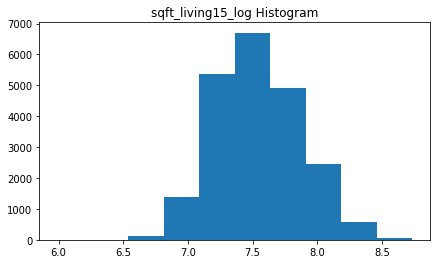

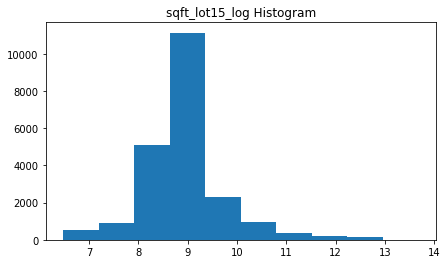

In [12]:
for i in ['price_log', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']:
    plt.figure(figsize=[7,4])
    plt.hist(df2[i])
    plt.title(i+' Histogram')
    plt.show()

In [13]:
#scaling values

df_scaled = df2.copy(deep=True)


scalelist = ['bedrooms', 'bathrooms', 'floors', 'age',
             'waterfront', 'view', 'condition','grade', 'basement', 'lat', 'long',
             'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']
    
for col in scalelist:
    df_scaled.loc[:,col] = scale(df2.loc[:,col])


df_scaled.head(3)

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode,lat,long,age,basement,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,sqft_living15_log,sqft_lot15_log
0,-0.407191,-1.447417,-0.915420,-0.087177,-0.305775,-0.629167,-0.558870,98178,-0.352521,-0.306165,0.534004,-0.804007,12.309982,-1.122992,-0.388482,-0.752092,-1.035225,-0.395567
1,-0.407191,0.175636,0.936501,-0.087177,-0.305775,-0.629167,-0.558870,98125,1.161579,-0.746426,0.670185,1.243771,13.195614,0.709363,-0.113403,0.672563,-0.326665,-0.024606
2,-1.510339,-1.447417,-0.915420,-0.087177,-0.305775,-0.629167,-1.409594,98028,1.283544,-0.135742,1.317044,-0.804007,12.100712,-2.127877,0.244170,-1.750356,1.126439,0.041681


In [14]:
collist = df_scaled.columns.drop(['price_log'])

print(collist)

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode', 'lat', 'long', 'age', 'basement', 'sqft_living_log',
       'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log',
       'sqft_lot15_log'],
      dtype='object')


In [15]:
#ols

ols_model_1 = smf.ols(formula = 'price_log ~ bedrooms + bathrooms + floors + age + waterfront + view + condition + grade + zipcode + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log',
                      data = df_scaled).fit()

df_scaled['predicted_price_1'] = ols_model_1.predict(df_scaled[collist])


print(ols_model_1.summary())

mean_y = np.mean(df_scaled['price_log'])
sst = np.sum((df_scaled['predicted_price_1']-mean_y)**2)
sse = sst - ols_model_1.ssr

print('SSE: ', round(sse,2))
print('SSR: ', round(ols_model_1.ssr,2))
print('SST: ', round(sst,2))
print('MSE: ', round(ols_model_1.mse_model,2))
print('RMSE: ', round(np.sqrt(ols_model_1.mse_model),2))


                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     1929.
Date:                Sun, 08 Mar 2020   Prob (F-statistic):               0.00
Time:                        10:59:11   Log-Likelihood:                 6462.9
No. Observations:               21611   AIC:                        -1.275e+04
Df Residuals:                   21525   BIC:                        -1.207e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.6752      0.02

In [16]:
df_scaled['predicted_price_1_unlogged'] = np.exp(df_scaled['predicted_price_1'])
df_scaled['price'] = np.exp(df_scaled['price_log'])

df_scaled['resids_1'] = np.subtract(df_scaled['predicted_price_1_unlogged'], df_scaled['price'])

df_scaled[['price', 'predicted_price_1_unlogged', 'resids_1']].head()

,price,predicted_price_1_unlogged,resids_1
0,221900.0,234367.537662,12467.537662
1,538000.0,534961.028105,-3038.971895
2,180000.0,260402.731256,80402.731256
3,604000.0,525199.669067,-78800.330933
4,510000.0,474247.412664,-35752.587336


Mean of predicted values = 530273.0
STD of predicted values = 328158.0



Text(0.5, 0, 'Price')

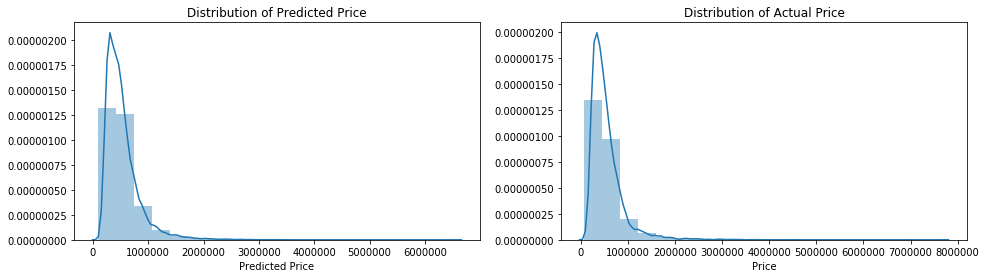

In [17]:
xmin = min(min(df_scaled['predicted_price_1_unlogged']), min(df_scaled['price']))
xmax = max(max(df_scaled['predicted_price_1_unlogged']), max(df_scaled['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled['predicted_price_1_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled['predicted_price_1_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled['predicted_price_1_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

In [18]:
def plot_resid_dist(resids):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    ## Plot a histogram
    sns.distplot(resids, bins=20, ax=ax[0])
    ax[0].set_title('Histogram of residuals')
    ax[0].set_xlabel('Residual values')
    ## Plot the Q-Q Normal plot
    ss.probplot(resids, plot = ax[1])
    ax[1].set_title('Q-Q Normal plot of residuals')
    plt.show()


def residual_plot(df, predicted_col, resids):
    RMSE = np.std(df[resids])
    plt.figure(figsize=[8,4])
    sns.scatterplot(x=predicted_col, y=resids, data=df)
    plt.axhline(0.0, color='red', linewidth=1.0)
    plt.axhline(2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.axhline(-2.0*RMSE, color='red', linestyle='dashed', linewidth=1.0)
    plt.title('Plot of residuals vs. predicted')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()      

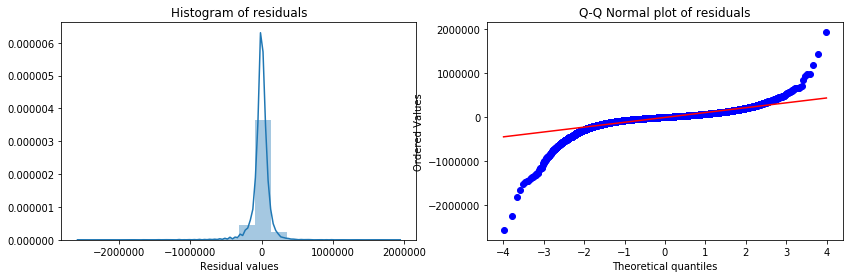

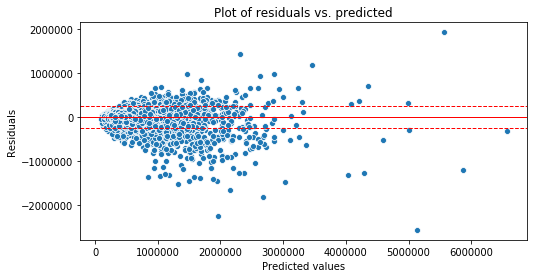

In [19]:
plot_resid_dist(df_scaled['resids_1'])

residual_plot(df_scaled, 'predicted_price_1_unlogged', 'resids_1')

In [20]:
#ridge regression

df_scaled2 = df_scaled.drop(['predicted_price_1', 'predicted_price_1_unlogged', 'price', 'resids_1'], axis = 1)

df_scaled2.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode', 'lat', 'long', 'age', 'basement', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [21]:
collist2 = ['bedrooms', 'bathrooms', 'floors', 'age',
            'view', 'waterfront', 'condition', 'grade', 'lat', 'long', 'basement',
            'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log'] # , 'zipcode'

In [22]:
X2 = df_scaled2[collist2]

y2 = df_scaled2['price_log']

C = np.dot(np.transpose(X2),X2)
C = np.multiply(1.0/float(X2.shape[0]), C)
print('Cov Matrix: ')
print(np.round(C,2))

Cov Matrix: 
[[ 1.    0.53  0.18 -0.16  0.08 -0.01  0.03  0.37 -0.01  0.13  0.17  0.64
   0.19  0.53  0.42  0.17]
 [ 0.53  1.    0.5  -0.51  0.19  0.06 -0.12  0.67  0.02  0.22  0.16  0.76
   0.1   0.69  0.57  0.09]
 [ 0.18  0.5   1.   -0.49  0.03  0.02 -0.26  0.46  0.05  0.13 -0.26  0.37
  -0.24  0.55  0.28 -0.23]
 [-0.16 -0.51 -0.49  1.    0.05  0.03  0.36 -0.45  0.15 -0.41  0.17 -0.35
   0.01 -0.45 -0.33 -0.02]
 [ 0.08  0.19  0.03  0.05  1.    0.4   0.05  0.25  0.01 -0.08  0.18  0.25
   0.12  0.16  0.26  0.12]
 [-0.01  0.06  0.02  0.03  0.4   1.    0.02  0.08 -0.01 -0.04  0.04  0.08
   0.07  0.06  0.08  0.08]
 [ 0.03 -0.12 -0.26  0.36  0.05  0.02  1.   -0.14 -0.02 -0.11  0.14 -0.05
   0.07 -0.15 -0.09  0.08]
 [ 0.37  0.67  0.46 -0.45  0.25  0.08 -0.14  1.    0.11  0.2   0.05  0.74
   0.18  0.74  0.69  0.18]
 [-0.01  0.02  0.05  0.15  0.01 -0.01 -0.02  0.11  1.   -0.14  0.14  0.04
  -0.15 -0.02  0.04 -0.14]
 [ 0.13  0.22  0.13 -0.41 -0.08 -0.04 -0.11  0.2  -0.14  1.   -0.24  0.26
   0

In [23]:
L, Q = np.linalg.eig(C)
np.round(L,4)

array([5.2276, 2.3006, 1.8774, 1.2838, 0.9767, 0.8951, 0.6941, 0.6449,
       0.5217, 0.0253, 0.0779, 0.4211, 0.3565, 0.1921, 0.2637, 0.2413])

In [24]:
def regularized_coefs(df, alphas, L1_wt=0.0, n_coefs=16,
                      formula = 'price_log ~ bedrooms + bathrooms + floors + age + view + waterfront + condition + grade + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log'):
    coefs = np.zeros((len(alphas),n_coefs + 1))
    for i,alpha in enumerate(alphas):
        temp_mod = smf.ols(formula, data=df).fit_regularized(alpha=alpha,L1_wt=L1_wt)
        coefs[i,:] = temp_mod.params
    return coefs


alphas = np.arange(0.01, 5.0, step = 0.01)

coefs = regularized_coefs(df_scaled2, alphas, L1_wt=0.0)
print(coefs[:5])
print('Shape: ', coefs.shape)

[[ 1.29186107e+01 -2.29969366e-02  5.35921067e-02  2.39336971e-02
   1.08817141e-01  4.85244813e-02  3.54877796e-02  3.97163277e-02
   1.89786882e-01  1.82888890e-01  7.04732501e-04  3.53926528e-02
   7.66485621e-02  1.35223624e-02  7.10941490e-02  7.34943765e-02
  -3.11068475e-02]
 [ 1.27919576e+01 -2.21346854e-02  5.31832011e-02  2.41673469e-02
   1.06427151e-01  4.88005019e-02  3.52216525e-02  3.95219489e-02
   1.86248643e-01  1.81739718e-01 -2.45767375e-04  3.52985136e-02
   7.73990525e-02  1.17402390e-02  7.07916244e-02  7.39328455e-02
  -2.87620832e-02]
 [ 1.26677639e+01 -2.12764427e-02  5.28196827e-02  2.43838801e-02
   1.04151986e-01  4.90471685e-02  3.49698598e-02  3.93263322e-02
   1.82936280e-01  1.80585750e-01 -1.12562325e-03  3.52590818e-02
   7.79165702e-02  1.03212302e-02  7.05761327e-02  7.43271534e-02
  -2.67941932e-02]
 [ 1.25459584e+01 -2.04280819e-02  5.24943165e-02  2.45860259e-02
   1.01984822e-01  4.92673246e-02  3.47302337e-02  3.91272501e-02
   1.79826588e-01  

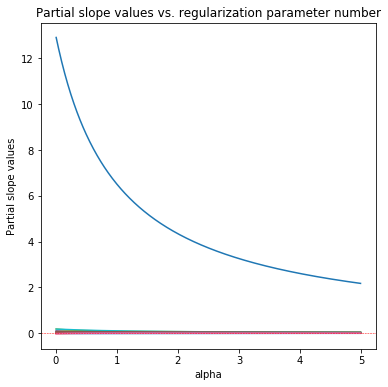

In [25]:
def plot_coefs(coefs, alphas, ylim=None):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    for i in range(coefs.shape[1]): # Iterate over coefficients
        ax.plot(alphas, coefs[:,i])
    ax.axhline(0.0, color='red', linestyle='--', linewidth=0.5)
    ax.set_ylabel('Partial slope values')
    ax.set_xlabel('alpha')
    ax.set_title('Partial slope values vs. regularization parameter number')
    if ylim is not None: ax.set_ylim(ylim)

plot_coefs(coefs, alphas)

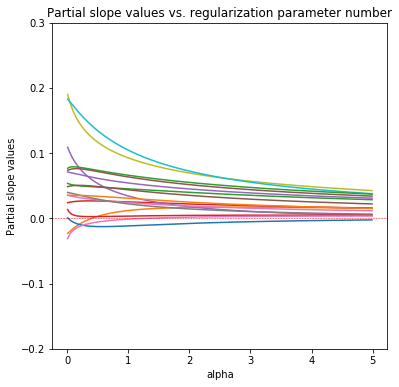

In [26]:
plot_coefs(coefs, alphas, ylim=(-0.2,0.3))

In [27]:
ols_model_2 = smf.ols('price_log ~ bedrooms + bathrooms + floors + age + view + waterfront + condition + grade + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log', 
                  data=df_scaled2).fit_regularized(alpha=0.001,L1_wt=0.0)

df_scaled2['predicted_price_2'] = ols_model_2.predict(df_scaled2[collist2])

print(df_scaled2[['price_log','predicted_price_2']])

       price_log  predicted_price_2
0      12.309982          12.551897
1      13.195614          13.333273
2      12.100712          12.807564
3      13.311329          12.911830
4      13.142166          12.994030
...          ...                ...
21608  12.793859          13.099876
21609  12.899220          12.909882
21610  12.904459          12.417198
21611  12.899220          12.879820
21612  12.691580          12.432870

[21611 rows x 2 columns]


In [28]:
df_scaled2['predicted_price_2_unlogged'] = np.exp(df_scaled2['predicted_price_2'])
df_scaled2['price'] = np.exp(df_scaled2['price_log'])

df_scaled2['resids_2'] = np.subtract(df_scaled2['predicted_price_2_unlogged'], df_scaled2['price'])

df_scaled2[['price', 'predicted_price_2_unlogged', 'resids_2']].head()

,price,predicted_price_2_unlogged,resids_2
0,221900.0,282630.899023,60730.899023
1,538000.0,617400.101226,79400.101226
2,180000.0,364967.826646,184967.826646
3,604000.0,405075.867535,-198924.132465
4,510000.0,439779.950316,-70220.049684


In [97]:
mean_y2 = np.mean(df_scaled2['price_log'])
sst2 = np.sum((df_scaled2['predicted_price_2']-mean_y2)**2)

rmse2 = round(np.sqrt(mean_squared_error(df_scaled2['price'], df_scaled2['predicted_price_2_unlogged'])),2)
print('RMSE: ', rmse2)

RMSE:  186252.77


Mean of predicted values = 514566.0
STD of predicted values = 295842.0



Text(0.5, 0, 'Price')

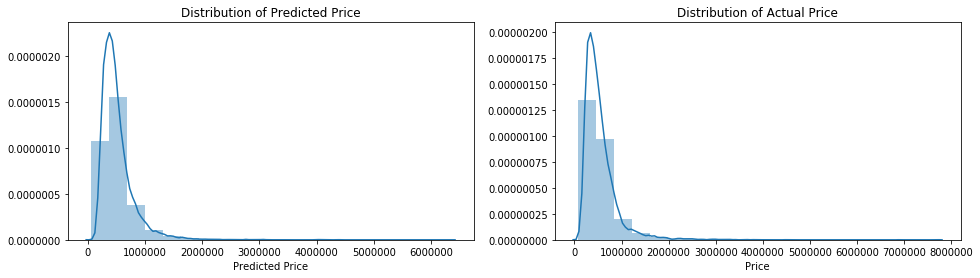

In [30]:
xmin = min(min(df_scaled2['predicted_price_2_unlogged']), min(df_scaled2['price']))
xmax = max(max(df_scaled2['predicted_price_2_unlogged']), max(df_scaled2['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled2['predicted_price_2_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled2['predicted_price_2_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled2['predicted_price_2_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled2['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

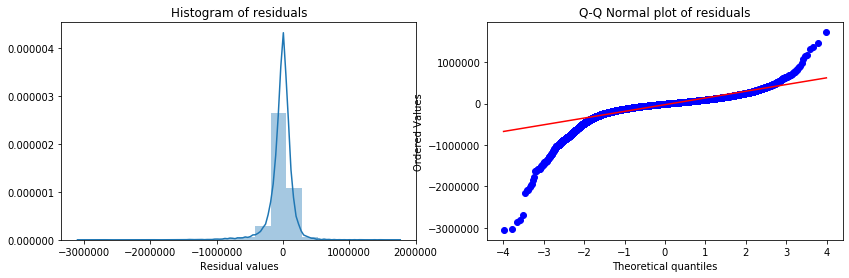

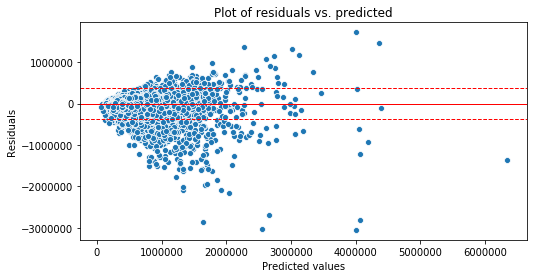

In [31]:
plot_resid_dist(df_scaled2['resids_2'])

residual_plot(df_scaled2, 'predicted_price_2_unlogged', 'resids_2')

In [72]:
#lasso regression

df_scaled4 = df_scaled.drop(['predicted_price_1', 'predicted_price_1_unlogged', 'price', 'resids_1'], axis = 1)

df_scaled4.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode', 'lat', 'long', 'age', 'basement', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [73]:
X4 = df_scaled4[collist2]

y4 = df_scaled4['price_log']

C4 = np.dot(np.transpose(X4),X4)
C4 = np.multiply(1.0/float(X4.shape[0]), C4)
print('Cov Matrix: ')
print(np.round(C4,2))

Cov Matrix: 
[[ 1.    0.53  0.18 -0.16  0.08 -0.01  0.03  0.37 -0.01  0.13  0.17  0.64
   0.19  0.53  0.42  0.17]
 [ 0.53  1.    0.5  -0.51  0.19  0.06 -0.12  0.67  0.02  0.22  0.16  0.76
   0.1   0.69  0.57  0.09]
 [ 0.18  0.5   1.   -0.49  0.03  0.02 -0.26  0.46  0.05  0.13 -0.26  0.37
  -0.24  0.55  0.28 -0.23]
 [-0.16 -0.51 -0.49  1.    0.05  0.03  0.36 -0.45  0.15 -0.41  0.17 -0.35
   0.01 -0.45 -0.33 -0.02]
 [ 0.08  0.19  0.03  0.05  1.    0.4   0.05  0.25  0.01 -0.08  0.18  0.25
   0.12  0.16  0.26  0.12]
 [-0.01  0.06  0.02  0.03  0.4   1.    0.02  0.08 -0.01 -0.04  0.04  0.08
   0.07  0.06  0.08  0.08]
 [ 0.03 -0.12 -0.26  0.36  0.05  0.02  1.   -0.14 -0.02 -0.11  0.14 -0.05
   0.07 -0.15 -0.09  0.08]
 [ 0.37  0.67  0.46 -0.45  0.25  0.08 -0.14  1.    0.11  0.2   0.05  0.74
   0.18  0.74  0.69  0.18]
 [-0.01  0.02  0.05  0.15  0.01 -0.01 -0.02  0.11  1.   -0.14  0.14  0.04
  -0.15 -0.02  0.04 -0.14]
 [ 0.13  0.22  0.13 -0.41 -0.08 -0.04 -0.11  0.2  -0.14  1.   -0.24  0.26
   0

In [74]:
L4, Q4 = np.linalg.eig(C4)
np.round(L4,4)

array([5.2276, 2.3006, 1.8774, 1.2838, 0.9767, 0.8951, 0.6941, 0.6449,
       0.5217, 0.0253, 0.0779, 0.4211, 0.3565, 0.1921, 0.2637, 0.2413])

In [76]:
coefs4 = regularized_coefs(df_scaled4, alphas, L1_wt=1.0)
print(coefs4[:5])
print('Shape: ', coefs4.shape)

[[1.30377968e+01 0.00000000e+00 9.03723978e-02 2.56771997e-02
  1.00032730e-01 4.60153831e-02 2.83221687e-02 3.28504265e-02
  2.30844763e-01 1.75176331e-01 0.00000000e+00 2.01262810e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05275940e-01
  0.00000000e+00]
 [1.30277968e+01 0.00000000e+00 3.44001015e-02 0.00000000e+00
  6.91079645e-02 4.72528452e-02 2.06105034e-02 1.93976511e-02
  1.95338039e-01 1.76132346e-01 0.00000000e+00 0.00000000e+00
  1.30671389e-01 0.00000000e+00 0.00000000e+00 5.12248713e-02
  0.00000000e+00]
 [1.30177968e+01 0.00000000e+00 1.92746122e-02 0.00000000e+00
  5.19565026e-02 4.63735317e-02 1.30005101e-02 1.24201016e-02
  1.87697285e-01 1.69714818e-01 0.00000000e+00 0.00000000e+00
  1.37297658e-01 0.00000000e+00 0.00000000e+00 4.49376174e-02
  0.00000000e+00]
 [1.30077968e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.36846065e-02 4.56446500e-02 5.40275965e-03 5.49231508e-03
  1.80571542e-01 1.63418561e-01 0.00000000e+00 0.00000000e+00
  1.46519590e-01

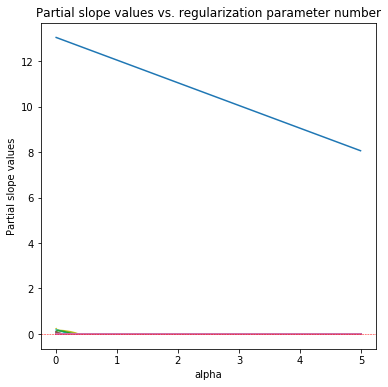

In [77]:
plot_coefs(coefs4, alphas)

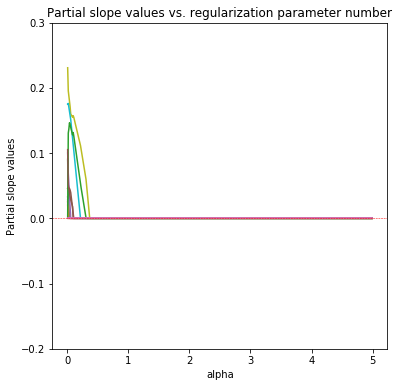

In [78]:
plot_coefs(coefs4, alphas, ylim=(-0.2,0.3))

In [79]:
ols_model_4 = smf.ols('price_log ~ bedrooms + bathrooms + floors + age + view + waterfront + condition + grade + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log', 
                  data=df_scaled4).fit_regularized(alpha=0.001,L1_wt=1.0)

df_scaled4['predicted_price_4'] = ols_model_4.predict(df_scaled4[collist2])

print(df_scaled4[['price_log','predicted_price_4']])

       price_log  predicted_price_4
0      12.309982          12.575215
1      13.195614          13.284688
2      12.100712          12.822120
3      13.311329          12.954349
4      13.142166          12.999065
...          ...                ...
21608  12.793859          13.132246
21609  12.899220          12.938210
21610  12.904459          12.441189
21611  12.899220          12.884499
21612  12.691580          12.453253

[21611 rows x 2 columns]


In [80]:
df_scaled4['predicted_price_4_unlogged'] = np.exp(df_scaled4['predicted_price_4'])
df_scaled4['price'] = np.exp(df_scaled4['price_log'])

df_scaled4['resids_4'] = np.subtract(df_scaled4['predicted_price_4_unlogged'], df_scaled4['price'])

df_scaled4[['price', 'predicted_price_4_unlogged', 'resids_4']].head()

,price,predicted_price_4_unlogged,resids_4
0,221900.0,289298.813870,67398.813870
1,538000.0,588121.204845,50121.204845
2,180000.0,370319.123480,190319.123480
3,604000.0,422670.980701,-181329.019299
4,510000.0,441999.824597,-68000.175403


In [98]:
mean_y4 = np.mean(df_scaled4['price_log'])
sst4 = np.sum((df_scaled4['predicted_price_4']-mean_y4)**2)

rmse4 = round(np.sqrt(mean_squared_error(df_scaled4['price'], df_scaled4['predicted_price_4_unlogged'])),2)
print('RMSE: ', rmse4)

RMSE:  186765.89


Mean of predicted values = 519991.0
STD of predicted values = 295462.0



Text(0.5, 0, 'Price')

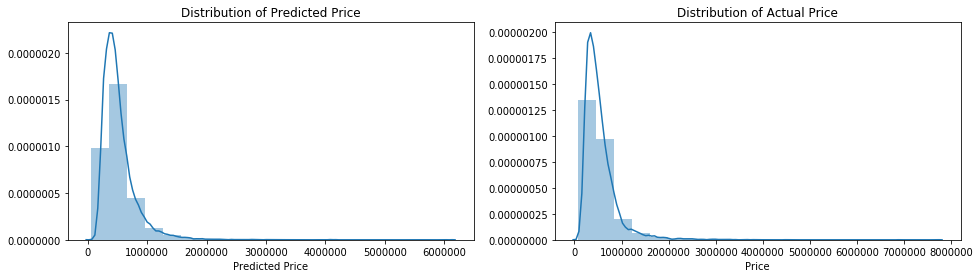

In [81]:
xmin = min(min(df_scaled4['predicted_price_4_unlogged']), min(df_scaled4['price']))
xmax = max(max(df_scaled4['predicted_price_4_unlogged']), max(df_scaled4['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled4['predicted_price_4_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled4['predicted_price_4_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled4['predicted_price_4_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled4['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

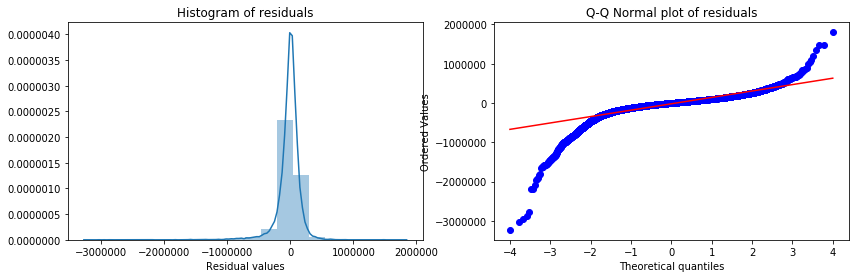

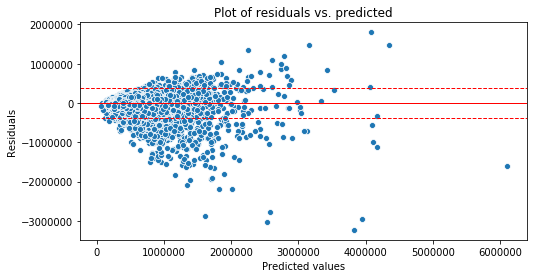

In [82]:
plot_resid_dist(df_scaled4['resids_4'])

residual_plot(df_scaled4, 'predicted_price_4_unlogged', 'resids_4')

In [83]:
#elastic net regression

df_scaled5 = df_scaled.drop(['predicted_price_1', 'predicted_price_1_unlogged', 'price', 'resids_1'], axis = 1)

df_scaled5.columns

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode', 'lat', 'long', 'age', 'basement', 'price_log',
       'sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log'],
      dtype='object')

In [84]:
X5 = df_scaled4[collist2]

y5 = df_scaled4['price_log']

C5 = np.dot(np.transpose(X5),X5)
C5 = np.multiply(1.0/float(X5.shape[0]), C5)
print('Cov Matrix: ')
print(np.round(C5,2))

Cov Matrix: 
[[ 1.    0.53  0.18 -0.16  0.08 -0.01  0.03  0.37 -0.01  0.13  0.17  0.64
   0.19  0.53  0.42  0.17]
 [ 0.53  1.    0.5  -0.51  0.19  0.06 -0.12  0.67  0.02  0.22  0.16  0.76
   0.1   0.69  0.57  0.09]
 [ 0.18  0.5   1.   -0.49  0.03  0.02 -0.26  0.46  0.05  0.13 -0.26  0.37
  -0.24  0.55  0.28 -0.23]
 [-0.16 -0.51 -0.49  1.    0.05  0.03  0.36 -0.45  0.15 -0.41  0.17 -0.35
   0.01 -0.45 -0.33 -0.02]
 [ 0.08  0.19  0.03  0.05  1.    0.4   0.05  0.25  0.01 -0.08  0.18  0.25
   0.12  0.16  0.26  0.12]
 [-0.01  0.06  0.02  0.03  0.4   1.    0.02  0.08 -0.01 -0.04  0.04  0.08
   0.07  0.06  0.08  0.08]
 [ 0.03 -0.12 -0.26  0.36  0.05  0.02  1.   -0.14 -0.02 -0.11  0.14 -0.05
   0.07 -0.15 -0.09  0.08]
 [ 0.37  0.67  0.46 -0.45  0.25  0.08 -0.14  1.    0.11  0.2   0.05  0.74
   0.18  0.74  0.69  0.18]
 [-0.01  0.02  0.05  0.15  0.01 -0.01 -0.02  0.11  1.   -0.14  0.14  0.04
  -0.15 -0.02  0.04 -0.14]
 [ 0.13  0.22  0.13 -0.41 -0.08 -0.04 -0.11  0.2  -0.14  1.   -0.24  0.26
   0

In [85]:
L5, Q5 = np.linalg.eig(C5)
np.round(L5,4)

array([5.2276, 2.3006, 1.8774, 1.2838, 0.9767, 0.8951, 0.6941, 0.6449,
       0.5217, 0.0253, 0.0779, 0.4211, 0.3565, 0.1921, 0.2637, 0.2413])

In [87]:
coefs5 = regularized_coefs(df_scaled5, alphas, L1_wt=0.5)
print(coefs5[:5])
print('Shape: ', coefs5.shape)

[[1.29779072e+01 0.00000000e+00 5.45239531e-02 2.09165830e-02
  1.00012929e-01 4.93069295e-02 3.16031867e-02 3.59696184e-02
  1.97076083e-01 1.82988127e-01 0.00000000e+00 5.56602434e-02
  0.00000000e+00 0.00000000e+00 1.13096206e-01 7.08954168e-02
  0.00000000e+00]
 [1.29087097e+01 0.00000000e+00 4.36561890e-02 2.11815176e-02
  8.91778278e-02 4.86500189e-02 2.77601039e-02 2.85372749e-02
  1.94978093e-01 1.79735208e-01 0.00000000e+00 3.45706109e-03
  1.22276540e-01 0.00000000e+00 0.00000000e+00 6.22074614e-02
  0.00000000e+00]
 [1.28401939e+01 0.00000000e+00 3.99967560e-02 1.27424437e-02
  7.87170982e-02 4.84197609e-02 2.39886283e-02 2.42988930e-02
  1.91048953e-01 1.76778867e-01 0.00000000e+00 0.00000000e+00
  1.25764073e-01 0.00000000e+00 0.00000000e+00 5.83049548e-02
  0.00000000e+00]
 [1.27723498e+01 0.00000000e+00 3.73253159e-02 0.00000000e+00
  6.67035845e-02 4.74905878e-02 2.04754632e-02 1.94074078e-02
  1.88899386e-01 1.73655463e-01 0.00000000e+00 0.00000000e+00
  1.27362929e-01

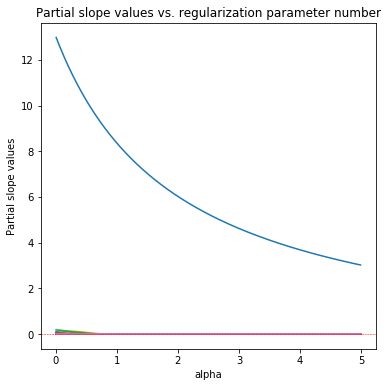

In [88]:
plot_coefs(coefs5, alphas)

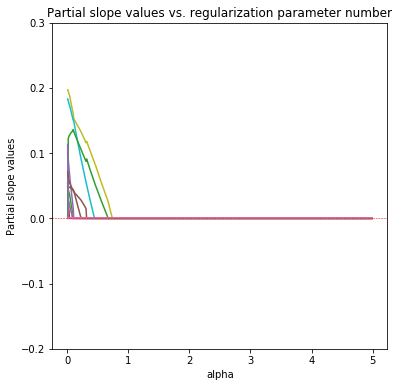

In [89]:
plot_coefs(coefs5, alphas, ylim=(-0.2,0.3))

In [90]:
ols_model_5 = smf.ols('price_log ~ bedrooms + bathrooms + floors + age + view + waterfront + condition + grade + lat + long + basement + sqft_living_log + sqft_lot_log + sqft_above_log + sqft_living15_log + sqft_lot15_log', 
                  data=df_scaled5).fit_regularized(alpha=0.001,L1_wt=0.5)

df_scaled5['predicted_price_5'] = ols_model_5.predict(df_scaled5[collist2])

print(df_scaled5[['price_log','predicted_price_5']])

       price_log  predicted_price_5
0      12.309982          12.569645
1      13.195614          13.312498
2      12.100712          12.809737
3      13.311329          12.922383
4      13.142166          12.996726
...          ...                ...
21608  12.793859          13.109436
21609  12.899220          12.929761
21610  12.904459          12.424512
21611  12.899220          12.877866
21612  12.691580          12.438456

[21611 rows x 2 columns]


In [91]:
df_scaled5['predicted_price_5_unlogged'] = np.exp(df_scaled5['predicted_price_5'])
df_scaled5['price'] = np.exp(df_scaled5['price_log'])

df_scaled5['resids_5'] = np.subtract(df_scaled5['predicted_price_5_unlogged'], df_scaled5['price'])

df_scaled5[['price', 'predicted_price_5_unlogged', 'resids_5']].head()

,price,predicted_price_5_unlogged,resids_5
0,221900.0,287691.712690,65791.712690
1,538000.0,604706.118620,66706.118620
2,180000.0,365761.526802,185761.526802
3,604000.0,409373.233839,-194626.766161
4,510000.0,440967.356779,-69032.643221


In [99]:
mean_y5 = np.mean(df_scaled5['price_log'])
sst5 = np.sum((df_scaled5['predicted_price_5']-mean_y5)**2)

rmse5 = round(np.sqrt(mean_squared_error(df_scaled5['price'], df_scaled5['predicted_price_5_unlogged'])),2)
print('RMSE: ', rmse5)

RMSE:  186276.73


Mean of predicted values = 517290.0
STD of predicted values = 295918.0



Text(0.5, 0, 'Price')

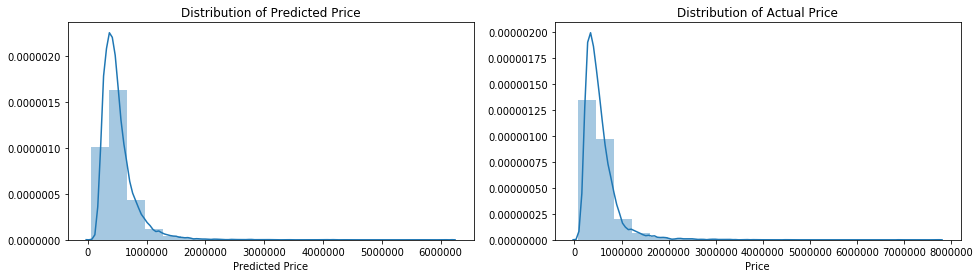

In [92]:
xmin = min(min(df_scaled5['predicted_price_5_unlogged']), min(df_scaled5['price']))
xmax = max(max(df_scaled5['predicted_price_5_unlogged']), max(df_scaled5['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled5['predicted_price_5_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled5['predicted_price_5_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
sns.distplot(df_scaled5['predicted_price_5_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled5['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

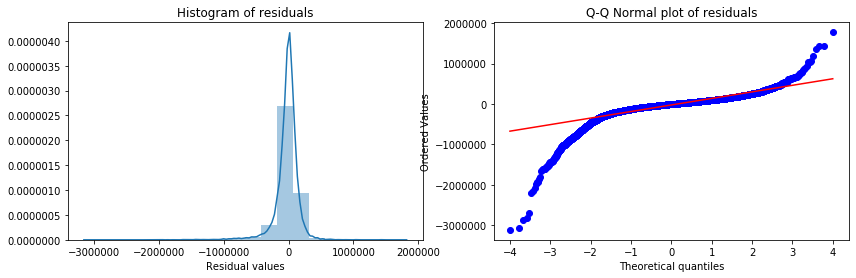

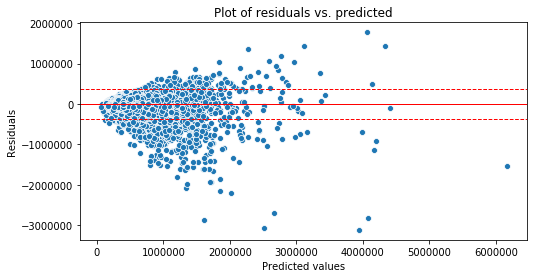

In [93]:
plot_resid_dist(df_scaled5['resids_5'])

residual_plot(df_scaled5, 'predicted_price_5_unlogged', 'resids_5')

In [32]:
print(collist2)

['bedrooms', 'bathrooms', 'floors', 'age', 'view', 'waterfront', 'condition', 'grade', 'lat', 'long', 'basement', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_living15_log', 'sqft_lot15_log']


In [33]:
df_scaled3 = df_scaled.drop(['predicted_price_1', 'predicted_price_1_unlogged', 'price', 'resids_1'], axis = 1)

In [34]:
X3 = df_scaled3[collist2]

y3 = df_scaled3['price_log']

print('Head of label matrix \n{}\n'.format(y3[:3]))
print('Design matrix \n{}'.format(X3[:3]))

Head of label matrix 
0    12.309982
1    13.195614
2    12.100712
Name: price_log, dtype: float64

Design matrix 
   bedrooms  bathrooms    floors       age      view  waterfront  condition  \
0 -0.407191  -1.447417 -0.915420  0.534004 -0.305775   -0.087177  -0.629167   
1 -0.407191   0.175636  0.936501  0.670185 -0.305775   -0.087177  -0.629167   
2 -1.510339  -1.447417 -0.915420  1.317044 -0.305775   -0.087177  -0.629167   

      grade       lat      long  basement  sqft_living_log  sqft_lot_log  \
0 -0.558870 -0.352521 -0.306165 -0.804007        -1.122992     -0.388482   
1 -0.558870  1.161579 -0.746426  1.243771         0.709363     -0.113403   
2 -1.409594  1.283544 -0.135742 -0.804007        -2.127877      0.244170   

   sqft_above_log  sqft_living15_log  sqft_lot15_log  
0       -0.752092          -1.035225       -0.395567  
1        0.672563          -0.326665       -0.024606  
2       -1.750356           1.126439        0.041681  


In [35]:
#perform svd -- svd(A) = U . s . Vt

U, s, Vt = np.linalg.svd(X3, full_matrices=False)
print('For matrix X: \n{}\n'.format(np.round(X3,3)[:3]))
print('U: \n{}\n'.format(np.round(U,3)[:3]))
print('s: \n{}\n'.format(np.round(s,3)))
print('Vt: \n{}'.format(np.round(Vt,3)[:3]))

For matrix X: 
   bedrooms  bathrooms  floors    age   view  waterfront  condition  grade  \
0    -0.407     -1.447  -0.915  0.534 -0.306      -0.087     -0.629 -0.559   
1    -0.407      0.176   0.937  0.670 -0.306      -0.087     -0.629 -0.559   
2    -1.510     -1.447  -0.915  1.317 -0.306      -0.087     -0.629 -1.410   

     lat   long  basement  sqft_living_log  sqft_lot_log  sqft_above_log  \
0 -0.353 -0.306    -0.804           -1.123        -0.388          -0.752   
1  1.162 -0.746     1.244            0.709        -0.113           0.673   
2  1.284 -0.136    -0.804           -2.128         0.244          -1.750   

   sqft_living15_log  sqft_lot15_log  
0             -1.035          -0.396  
1             -0.327          -0.025  
2              1.126           0.042  

U: 
[[-0.007 -0.     0.004 -0.002  0.    -0.001 -0.006 -0.001  0.003  0.005
  -0.005 -0.004  0.007 -0.     0.001  0.001]
 [ 0.     0.003 -0.005  0.003  0.007 -0.003 -0.004 -0.002 -0.005 -0.005
   0.016  0.002 -

In [36]:
#create a diagonal single value matrix
S = np.diag(s)

#matrix multiply:  U * S * Vt
X_reconstructed = np.dot(U, np.dot(S, Vt))

#print('X_reconstructed: \n{}'.format(X_reconstructed))
print('X and X_reconstructed are identical: {}'.format(np.allclose(X3, X_reconstructed)))

X and X_reconstructed are identical: True


In [37]:
print('Singular Values: ', np.round(s))
print('Count of Singular Values: ', len(s))

Singular Values:  [336. 223. 201. 167. 145. 139. 122. 118. 106.  95.  88.  75.  72.  64.
  41.  23.]
Count of Singular Values:  16


Text(0.5, 0, 'Singular value number')

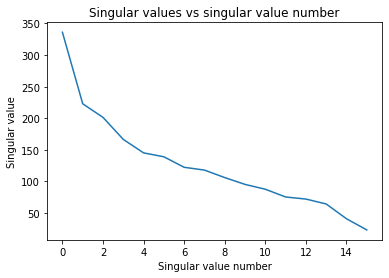

In [38]:
plt.plot(s)
plt.title('Singular values vs singular value number')
plt.ylabel('Singular value')
plt.xlabel('Singular value number')

In [39]:
#calculate D_dagger or the inverse of s with cut off

def set_d(s, cutoff=0.2):
    d = []
    
    for sv in s:
        if(sv > cutoff * s[0]): 
            d.append(1.0/sv)
        else: 
            d.append(0.0)
    
    return d


D_dagger = np.diag(set_d(s))
np.round(D_dagger,4)

array([[0.003 , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.0045, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.005 , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.006 , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.0069, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.0072, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0082, 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.

In [40]:
non_zero = np.nonzero(set_d(s))
n_elements = len(non_zero[0])
print(n_elements)

13


In [41]:
#create D_dagger_reduced matrix

D_dagger_reduced = D_dagger[:n_elements, :n_elements]
print('Shape: ', D_dagger_reduced.shape)
print(np.round(D_dagger_reduced,3), '\n')


#create U_reduced matrix

U_reduced = U[:,:n_elements]
print('Shape: ', U_reduced.shape)
print(np.round(U_reduced,3), '\n')


#create Vt_reduced matrix

Vt_reduced = Vt[:n_elements,:]
print('Shape: ', Vt_reduced.shape)
print(np.round(Vt_reduced,3), '\n')

Shape:  (13, 13)
[[0.003 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.004 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.005 0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.006 0.    0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.007 0.    0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.007 0.    0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.008 0.    0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.008 0.    0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.009 0.    0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01  0.    0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.011 0.
  0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.013
  0.   ]
 [0.    0.    0.    

In [42]:
#calculate the pseudo inverse and matrix coefficients using the reduced dimension
#A_dagger = V . D_dagger . U_transpose

MP_inverse = np.dot(np.transpose(Vt_reduced), np.dot(D_dagger_reduced, np.transpose(U_reduced)))

print('MP inverse matrix: \n', MP_inverse, '\n')
print('MP inverse shape:', MP_inverse.shape, '\n')


b = np.dot(MP_inverse, df_scaled3['price_log'])
print('Model Coefficients: \n', np.round(b,4))

MP inverse matrix: 
 [[ 3.51267739e-05 -4.80974587e-05 -5.64507035e-05 ...  2.45029554e-05
  -1.67557266e-05  2.43348660e-05]
 [-7.15277833e-05  4.56377690e-05 -1.56990683e-05 ... -1.44548367e-04
   3.86652701e-05 -1.42833397e-04]
 [-6.10232566e-05  1.26321628e-04 -6.41345386e-06 ...  6.89862915e-05
  -3.56057515e-05  5.57598852e-05]
 ...
 [ 1.00835170e-05  2.99535139e-06 -3.30558154e-05 ... -3.75609082e-05
   1.85231902e-05 -3.31949223e-05]
 [-4.24323312e-05 -1.39974969e-05  2.64833405e-04 ... -6.67971758e-05
  -9.55093055e-05 -6.14910841e-05]
 [-2.15969286e-05  3.13313686e-05  9.75263377e-06 ... -5.87164954e-06
  -6.80811849e-05 -2.26886968e-05]] 

MP inverse shape: (16, 21611) 

Model Coefficients: 
 [-0.0335  0.0391  0.0172  0.1022  0.0509  0.0349  0.0404  0.1754  0.1868
 -0.001   0.0379  0.1025 -0.0065  0.0913  0.0626 -0.0168]


In [43]:
df_scaled3.loc[:,'predicted_price_3'] = np.dot(X3, b)

print(df_scaled3.head(3))

   bedrooms  bathrooms    floors  waterfront      view  condition     grade  \
0 -0.407191  -1.447417 -0.915420   -0.087177 -0.305775  -0.629167 -0.558870   
1 -0.407191   0.175636  0.936501   -0.087177 -0.305775  -0.629167 -0.558870   
2 -1.510339  -1.447417 -0.915420   -0.087177 -0.305775  -0.629167 -1.409594   

  zipcode       lat      long       age  basement  price_log  sqft_living_log  \
0   98178 -0.352521 -0.306165  0.534004 -0.804007  12.309982        -1.122992   
1   98125  1.161579 -0.746426  0.670185  1.243771  13.195614         0.709363   
2   98028  1.283544 -0.135742  1.317044 -0.804007  12.100712        -2.127877   

   sqft_lot_log  sqft_above_log  sqft_living15_log  sqft_lot15_log  \
0     -0.388482       -0.752092          -1.035225       -0.395567   
1     -0.113403        0.672563          -0.326665       -0.024606   
2      0.244170       -1.750356           1.126439        0.041681   

   predicted_price_3  
0          -0.481638  
1           0.342728  
2       

In [44]:
df_scaled3['predicted_price_3_unlogged'] = np.exp(df_scaled3['predicted_price_3'])
df_scaled3['price'] = np.exp(df_scaled3['price_log'])

df_scaled3['resids_3'] = np.subtract(df_scaled3['predicted_price_3_unlogged'], df_scaled3['price'])

df_scaled3[['price', 'predicted_price_3_unlogged', 'resids_3']].head()

,price,predicted_price_3_unlogged,resids_3
0,221900.0,0.617770,-221899.382230
1,538000.0,1.408785,-537998.591215
2,180000.0,0.756818,-179999.243182
3,604000.0,0.875905,-603999.124095
4,510000.0,0.960866,-509999.039134


Mean of predicted values = 1.0
STD of predicted values = 1.0



Text(0.5, 0, 'Price')

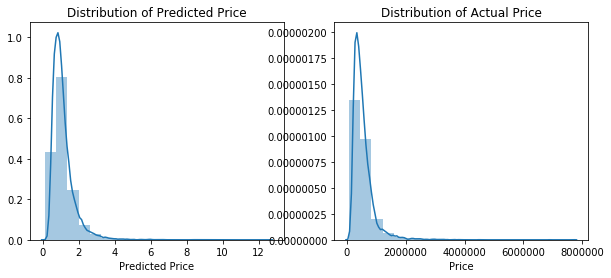

In [45]:
xmin = min(min(df_scaled3['predicted_price_3_unlogged']), min(df_scaled3['price']))
xmax = max(max(df_scaled3['predicted_price_3_unlogged']), max(df_scaled3['price']))

print('Mean of predicted values = {}'.format(np.round(np.mean(df_scaled3['predicted_price_3_unlogged'])),4))
print('STD of predicted values = {}\n'.format(np.round(np.std(df_scaled3['predicted_price_3_unlogged'])),4))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.distplot(df_scaled3['predicted_price_3_unlogged'], bins=20, ax=ax[0])
ax[0].set_title('Distribution of Predicted Price')
ax[0].set_xlabel('Predicted Price')
#ax[0].set_xlim(0,xmax)

sns.distplot(df_scaled3['price'], bins=20, ax=ax[1])
ax[1].set_title('Distribution of Actual Price')
ax[1].set_xlabel('Price')
#_=ax[1].set_xlim(0,xmax)

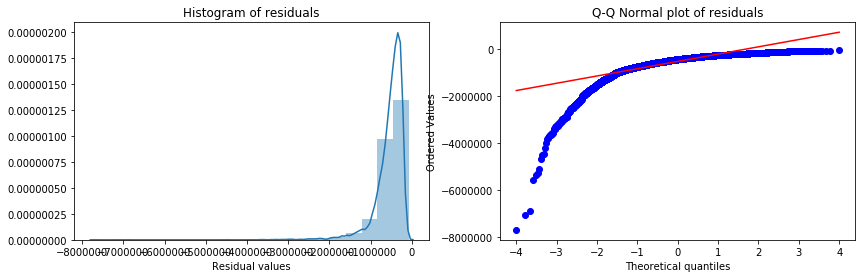

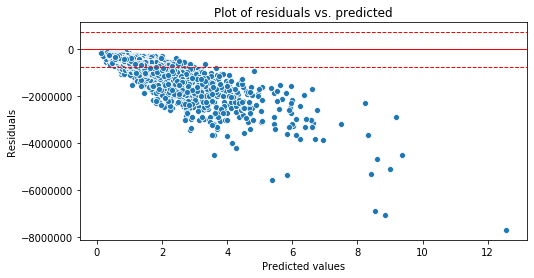

In [46]:
df_scaled3.loc[:,'resids_3'] = np.subtract(df_scaled3.loc[:,'predicted_price_3_unlogged'],df_scaled3.loc[:,'price'])

plot_resid_dist(df_scaled3.loc[:,'resids_3'])
residual_plot(df_scaled3, 'predicted_price_3_unlogged', 'resids_3')